<a href="https://colab.research.google.com/github/kcresswell/Python/blob/master/ML_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Customer's Likelihood To Churn

> Last Updated: 7/29/22 by Kayla Cresswell









# Install required python packages

In [ ]:
from IPython.display import clear_output
clear_output()

In [ ]:
!pip install catboost
clear_output() # clear cell output after installation

In [ ]:
# SHAP package for explainable AI 
!pip install shap
import shap

clear_output() # clear the output of the cell after installation

In [ ]:
# pretty print dataframes/tables
# link: https://colab.research.google.com/notebooks/data_table.ipynb
from google.colab import data_table
data_table.enable_dataframe_formatter()

clear_output() # clear the output of the cell after installation

In [ ]:
# DTALE helps visualize features to determine which ones to use 
# docs: https://pypi.org/project/dtale/
!pip install -U dtale 

import dtale
import dtale.app as dtale_app

dtale_app.USE_COLAB = True 

clear_output() # clear the output of the cell after installation

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

clear_output() # clear cell output after imports 

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df = pd.read_csv('/content/bquxjob_1ca6007c_18247a7f1dc.csv')
# read from drive 
df = pd.read_csv('/content/drive/Shareddrives/Analytics & BI/Projects/ML_Projects/220728_ml_churn_data.csv')
 
# clean up dataframe
df = df[['sf_account_id', 'sf_account_name', 'company_name', 'industry', 'segment', 'weeks_to_project_completion', 'number_of_cases', 
         'arr', 'churned_arr', 'arr_ranking', 'health_score', 'csm_norm',	'csat_norm',	'nps_norm',	'usage_norm', 'license_usage_percentage', 
         'csm_owner', 'csm_sentiment_numeric', 'admin_logins_last_month', 'rep_logins_last_month', 'data_source_incl_salesforce', 'is_churned']]

df['arr_feature'] = df[['arr','churned_arr']].max(axis=1) # get the max value between 'arr' and 'churned_arr' to eliminate null values in the df


# df = df.iloc[1: , :] # remove first row of dataframe, for some reason the headers were coming in twice

display(df.head(5))
 

,sf_account_id,sf_account_name,company_name,industry,segment,weeks_to_project_completion,number_of_cases,arr,churned_arr,arr_ranking,...,nps_norm,usage_norm,license_usage_percentage,csm_owner,csm_sentiment_numeric,admin_logins_last_month,rep_logins_last_month,data_source_incl_salesforce,is_churned,arr_feature
0,0016Q00001bFnvXQAS,Sterling Computers Corporation,Sterling Computers Corporation,Custom Software & IT Services,Mid-Market,NaN,NaN,61200.0,NaN,3,...,NaN,NaN,NaN,Randy Phommahaxay,NaN,NaN,NaN,0,0,61200.0
1,0016Q00001bCpbPQAS,PathAI Diagnostics,PathAI Diagnostics,Medical Laboratories & Imaging Centers,Mid-Market,NaN,NaN,21600.0,NaN,1,...,NaN,NaN,NaN,Randy Phommahaxay,NaN,NaN,NaN,0,0,21600.0
2,0014P00002l3IDfQAM,Collins Aerospace Companies,Collins Aerospace Companies,Aerospace & Defense,Enterprise,NaN,NaN,48120.0,NaN,2,...,NaN,NaN,NaN,Brent Showerman,NaN,NaN,NaN,0,0,48120.0
3,0014P00002l3TgOQAU,Zensho Agency Inc.,Zensho Agency Inc.,Staffing & Recruiting,Mid-Market,NaN,NaN,0.0,12180.0,1,...,0.641119,1.0,NaN,Adam Packard,NaN,NaN,NaN,0,1,12180.0
4,0014P00002cbqM1QAI,Experience Inc,Experience Inc,HR & Staffing,Enterprise,NaN,NaN,0.0,7500.0,1,...,1.000000,1.0,NaN,Adam Packard,NaN,NaN,NaN,0,1,7500.0


In [ ]:
# Set datatypes for the dataframe 
datatypes = {
    'sf_account_id': 'category', 
    'sf_account_name': 'category', 
    'company_name': 'category', 
    'industry': 'category', 
    'segment': 'category', 
    'weeks_to_project_completion': 'float64', 
    'number_of_cases': 'float64', 
    'csm_norm': 'float64',
    'csat_norm': 'float64', 
    'nps_norm': 'float64', 
    'usage_norm': 'float64',
    'health_score': 'float64', 
    'license_usage_percentage': 'float64', 
    'csm_owner': 'category', 
    'csm_sentiment_numeric': 'float64', 
    'admin_logins_last_month': 'float64', 
    'rep_logins_last_month': 'float64', 
    'data_source_incl_salesforce': 'float64',
    'arr_ranking': 'int64',  
    'arr': 'float64', 
    'churned_arr': 'float64', 
    'arr_feature' : 'float64',
    'is_churned': 'int64'
}


df = df.astype(datatypes)
df_raw = df.copy()  

In [188]:
# Create new dataframe with necessary columns
df_reduced = df_raw[['industry', 'segment', 'arr_feature', 'csm_owner', 'is_churned', 'data_source_incl_salesforce']] 
# 'arr_ranking' makes it worse, 'health_score' puts it up to 92% and w/o it it's about 87% 

### Check out features using the [dtale](https://pypi.org/project/dtale/) library

In [220]:
dtale.show(df_raw)

https://f9s15p7r63a-496ff2e9c6d22116-40000-colab.googleusercontent.com/dtale/main/1

# Create and Train the CatBoost Machine Learning Model 
*CatBoost works well with categorical variables (Industry, Segment, CSM Owner)*

In [190]:
X = df_reduced.copy()
y = X.pop('is_churned')
 
# Split the data into train and test data with 20% of the data to test the model, stratify makes sure that the churned clients aren't all in the same bucket
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# y_test.describe() # check out mean of y_test and y_train to see % of churn in each dataset (stratify splits it out pretty dang evenly!)

In [191]:
# Select the ML Model type
# industry, sf indicator, segment 
model = CatBoostClassifier(cat_features=['industry', 'segment', 'csm_owner']) 

# Fit the model to the training data
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test))

clear_output() # clear model fitting output and print the summary below

print(f'Model Trained!')
print(f'Best Iteration: {model.best_iteration_}')
print(f'Best Loss Info: {model.best_score_}')

Model Trained!
Best Iteration: 115
Best Loss Info: {'learn': {'Logloss': 0.027211389827749417}, 'validation': {'Logloss': 0.2543439259841177}}


In [204]:
# Select the best features for the model 
model.select_features(
                X_train,
                y=y_train, 
                features_for_select= X_train.columns.to_list(),
                num_features_to_select=4,
                train_final_model=False,
                verbose=False,
                plot=True) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.006475
Step #1 out of 1
Feature #1 eliminated


{'eliminated_features': [1],
 'eliminated_features_names': ['segment'],
 'loss_graph': {'loss_values': [0.15214808951188658, 0.15571417890753503],
  'main_indices': [0],
  'removed_features_count': [0, 1]},
 'selected_features': [0, 2, 3, 4],
 'selected_features_names': ['industry',
  'arr_feature',
  'csm_owner',
  'data_source_incl_salesforce']}

## Review Model Breakdown

In [193]:
preds_test = model.predict(X_test)

# Print the accuracy of the test 
print(f'Model Accuracy on test data: {metrics.accuracy_score(y_test, preds_test)*100}%')

Model Accuracy on test data: 89.41176470588236%


### Confusion Matrix

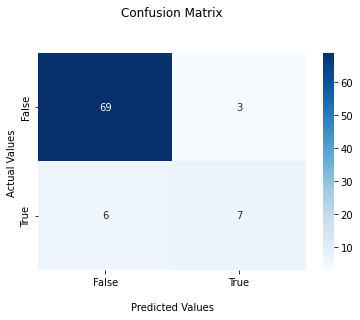

In [248]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, preds_test)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True']) 

plt.show()

### Review percent likelihood to churn for each client

In [239]:
# Get the % likelihood to churn for each client
x_preds_bool = model.predict(X) 
x_preds = model.predict_proba(X)[:, 1] # get second element out (likelihood to churn) of each 
X['likelihood_to_churn'] = x_preds
X['bool_likelihood_to_churn'] = x_preds_bool # todo rename? 
np.set_printoptions(formatter={'float_kind':'{:f}'.format}) # prints likelihood_to_churn scientific notation as a float

df_account_columns = df_raw[['sf_account_id', 'sf_account_name', 'is_churned']] 
df_preds = pd.merge(df_account_columns, X, left_index=True, right_index=True)
df_preds = df_preds[['sf_account_id', 'sf_account_name', 'likelihood_to_churn', 'bool_likelihood_to_churn', 'is_churned']] 

df_preds.likelihood_to_churn = df_preds.likelihood_to_churn.round(4) * 100 # convert percentage out of scientific notation and into percent format 

display(df_preds)

,sf_account_id,sf_account_name,likelihood_to_churn,bool_likelihood_to_churn,is_churned
1,0016Q00001bCpbPQAS,PathAI Diagnostics,5.95,0,0
2,0014P00002l3IDfQAM,Collins Aerospace Companies,3.96,0,0
3,0014P00002l3TgOQAU,Zensho Agency Inc.,77.96,1,1
4,0014P00002cbqM1QAI,Experience Inc,73.01,1,1
5,0014P00002LCNYFQA5,"Workfront, Inc.",36.83,0,1
...,...,...,...,...,...
418,0014P00002BVowtQAD,GoGuardian,3.40,0,0
419,0014P00002zYXlTQAW,GlobalWebIndex,3.14,0,0
420,0014P00002DYbVGQA1,Cloudbeds,2.43,0,0
421,0014P00002l3DXmQAM,Chili Piper,5.27,0,0


### Visualizing the impact of each feature on the model

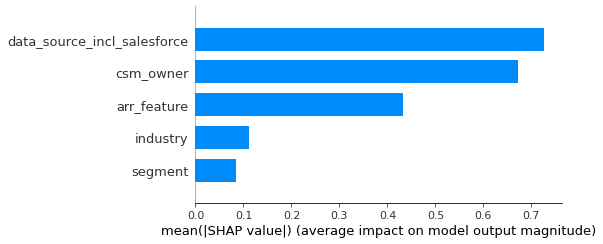

In [196]:
# SHAP can be used for CatBoost since it is a decision tree model 
explainer = shap.TreeExplainer(model = model)
shap_values = explainer.shap_values(X_train) # get values for training data 

shap.summary_plot(shap_values = shap_values, features = X_train, plot_type = 'bar')

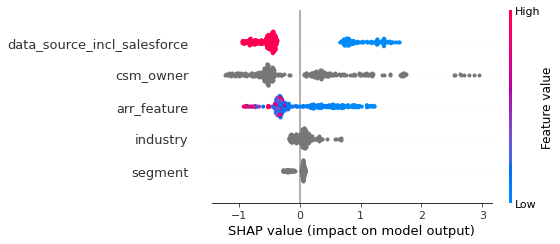

In [197]:
# categorical features are grayed out
shap.summary_plot(shap_values = shap_values, features = X_train)

#### Clients with a lower ARR value are more likely to churn

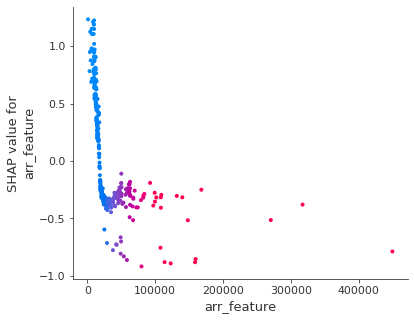

In [198]:
shap.dependence_plot(ind = 'arr_feature', shap_values = shap_values, features = X_train, interaction_index='arr_feature')

# Actionable Takeaways

## Clients Likely to Churn  

In [199]:
# get a list of clients that have not churned yet but h ave a likelihood to churn score of over 20% 
df_likely_to_churn = df_preds.copy()  

df_likely_to_churn = df_likely_to_churn[(df_likely_to_churn['is_churned'] == 0)]
df_likely_to_churn = df_likely_to_churn[(df_likely_to_churn['likelihood_to_churn'] >= 20.0)] 
df_likely_to_churn = df_likely_to_churn.sort_values(by='likelihood_to_churn', ascending=False)

display(df_likely_to_churn)

,sf_account_id,sf_account_name,likelihood_to_churn,bool_likelihood_to_churn,is_churned
129,0016Q00001YmGRzQAN,HiredScore,81.41,1,0
355,0014P00002BY3PkQAL,Destination Wealth Management,79.61,1,0
103,0014P00002QOPDgQAP,Candidate Labs,79.59,1,0
115,0014P00002l2VQQQA2,Country Places,77.26,1,0
113,0014P00002Z7si5QAB,Ingram Micro Commerce & Lifecycle Services,72.04,1,0
325,0014P00003Bc8o7QAB,Pinnacle,65.89,1,0
169,0014P00002zW51DQAS,Bollore Logistics,55.03,1,0
222,0014P00003DXpOaQAL,JobNimbus,32.38,0,0
417,0014P00002l5MDfQAM,Brinks Home Security,30.88,0,0
182,0014P00002acGvvQAE,Assa Abloy Global Solutions,28.90,0,0


### Visualize the features that impact a client's likelihood to churn

In [223]:
df_account_columns = df_raw[['sf_account_id', 'sf_account_name', 'is_churned']] 
df_all_likely_to_churn = pd.merge(df_likely_to_churn, X, left_index=True, right_index=True)
df_all_likely_to_churn = df_all_likely_to_churn[['sf_account_id', 'sf_account_name', 'likelihood_to_churn_x',
       'industry', 'segment', 'arr_feature', 'csm_owner', 'data_source_incl_salesforce']]

df_all_likely_to_churn.rename(columns = {'likelihood_to_churn_x':'likelihood_to_churn'}, inplace = True)
df_all_likely_to_churn.rename(columns = {'bool_likelihood_to_churn_x':'bool_likelihood_to_churn'}, inplace = True)
 
display(df_all_likely_to_churn)

,sf_account_id,sf_account_name,likelihood_to_churn,industry,segment,arr_feature,csm_owner,data_source_incl_salesforce
129,0016Q00001YmGRzQAN,HiredScore,81.41,Human Resources Software,Mid-Market,11499.72,Carolyn Passey,0.0
355,0014P00002BY3PkQAL,Destination Wealth Management,79.61,Financial Services,Mid-Market,6300.00,Adam Packard,0.0
103,0014P00002QOPDgQAP,Candidate Labs,79.59,Staffing & Recruiting,Mid-Market,9900.00,Adam Packard,0.0
115,0014P00002l2VQQQA2,Country Places,77.26,Real Estate,Mid-Market,9720.00,Erin Wasson,0.0
113,0014P00002Z7si5QAB,Ingram Micro Commerce & Lifecycle Services,72.04,Wholesale,Enterprise,6480.00,Adam Packard,0.0
325,0014P00003Bc8o7QAB,Pinnacle,65.89,Medical Devices,Mid-Market,14700.00,Erin Wasson,0.0
169,0014P00002zW51DQAS,Bollore Logistics,55.03,Transportation/Trucking/Railroad,Enterprise,14400.00,Erin Wasson,0.0
222,0014P00003DXpOaQAL,JobNimbus,32.38,Software,Mid-Market,28800.00,Adam Packard,0.0
417,0014P00002l5MDfQAM,Brinks Home Security,30.88,Security Products & Services,Enterprise,450000.00,Carolyn Passey,0.0
182,0014P00002acGvvQAE,Assa Abloy Global Solutions,28.90,Services,Enterprise,23760.00,Adam Packard,0.0


['0016Q00001YmGRzQAN' 'HiredScore' 81.41000000000001
 'Human Resources Software' 'Mid-Market' 11499.72 'Carolyn Passey' 0.0]


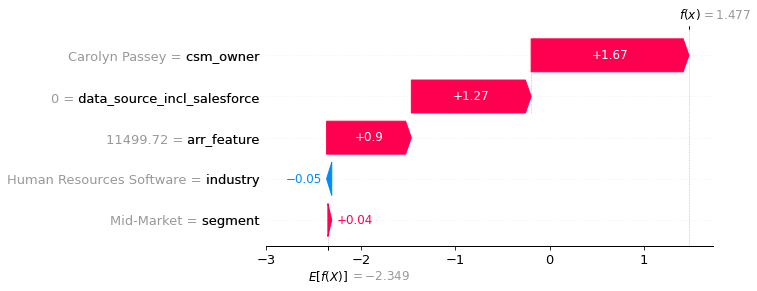

['0014P00002BY3PkQAL' 'Destination Wealth Management' 79.61
 'Financial Services' 'Mid-Market' 6300.0 'Adam Packard' 0.0]


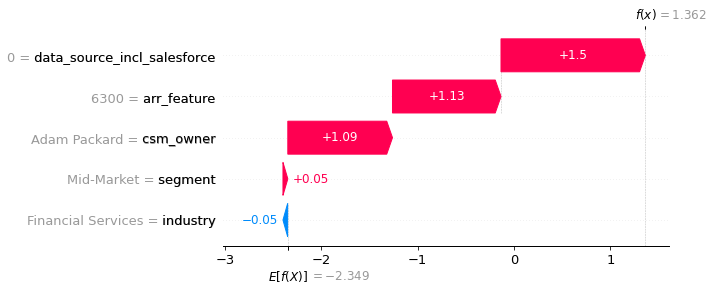

['0014P00002QOPDgQAP' 'Candidate Labs' 79.59 'Staffing & Recruiting'
 'Mid-Market' 9900.0 'Adam Packard' 0.0]


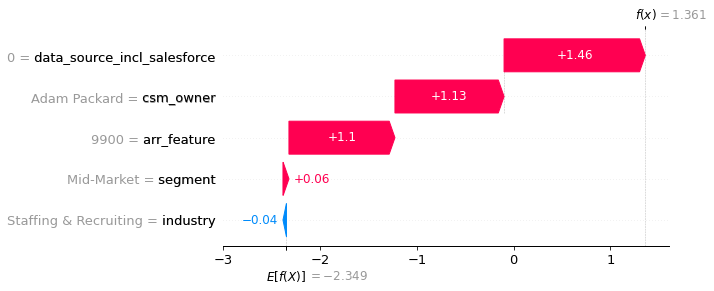

['0014P00002l2VQQQA2' 'Country Places' 77.25999999999999 'Real Estate'
 'Mid-Market' 9720.0 'Erin Wasson' 0.0]


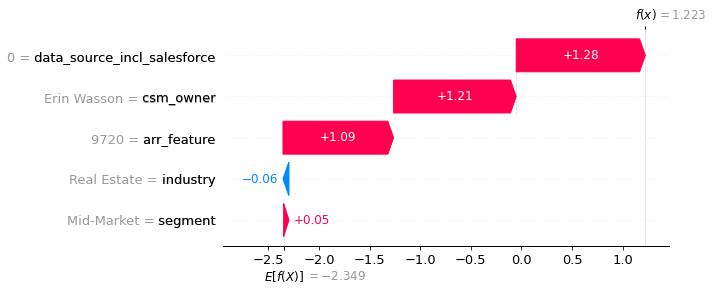

['0014P00002Z7si5QAB' 'Ingram Micro Commerce & Lifecycle Services' 72.04
 'Wholesale' 'Enterprise' 6480.0 'Adam Packard' 0.0]


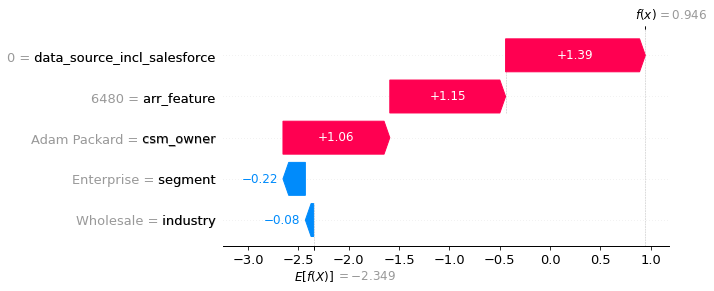

['0014P00003Bc8o7QAB' 'Pinnacle' 65.89 'Medical Devices' 'Mid-Market'
 14700.0 'Erin Wasson' 0.0]


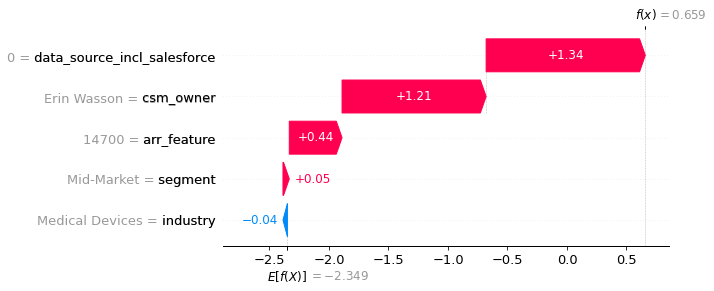

['0014P00002zW51DQAS' 'Bollore Logistics' 55.03
 'Transportation/Trucking/Railroad' 'Enterprise' 14400.0 'Erin Wasson' 0.0]


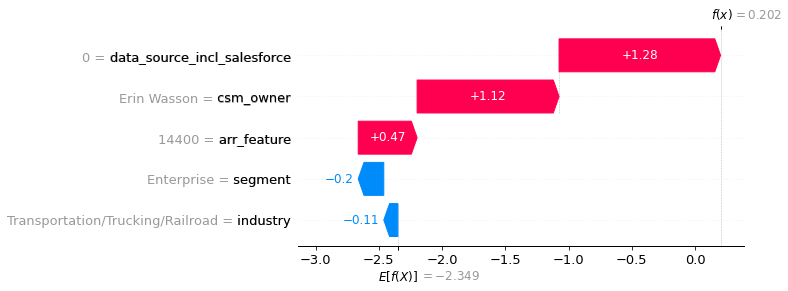

['0014P00003DXpOaQAL' 'JobNimbus' 32.379999999999995 'Software'
 'Mid-Market' 28800.0 'Adam Packard' 0.0]


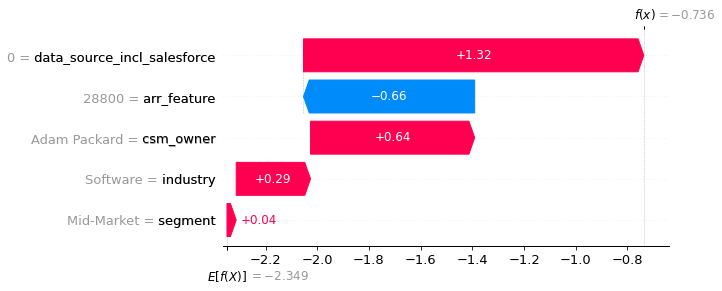

['0014P00002l5MDfQAM' 'Brinks Home Security' 30.880000000000003
 'Security Products & Services' 'Enterprise' 450000.0 'Carolyn Passey' 0.0]


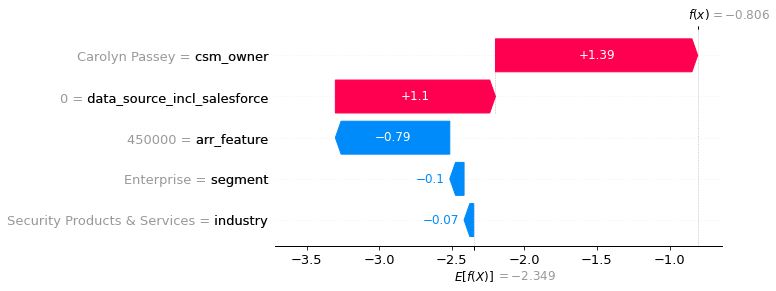

['0014P00002acGvvQAE' 'Assa Abloy Global Solutions' 28.9 'Services'
 'Enterprise' 23760.0 'Adam Packard' 0.0]


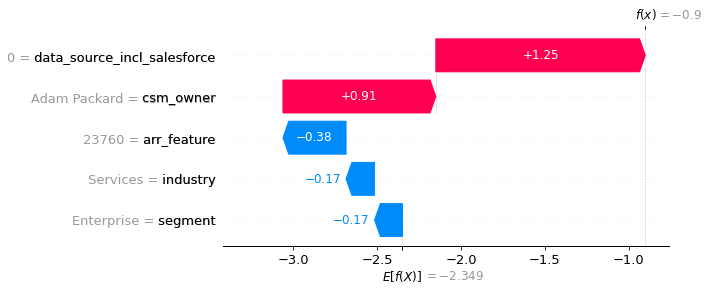

['0014P00002BVoo5QAD' 'Awardco' 26.75 'Software' 'Mid-Market' 37800.0
 'Adam Packard' 0.0]


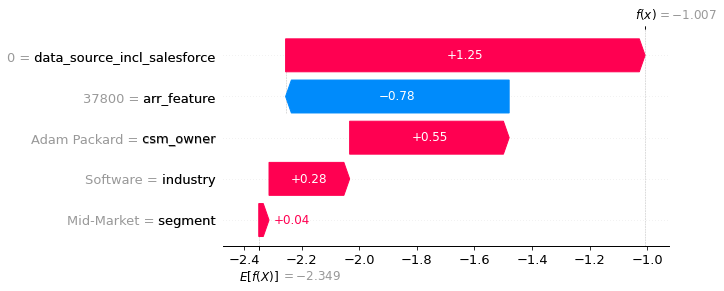

['0016Q00001XGo63QAD' 'Optimize Wealth Management' 26.66
 'Investment Banking' 'Mid-Market' 25200.0 'Erin Wasson' 0.0]


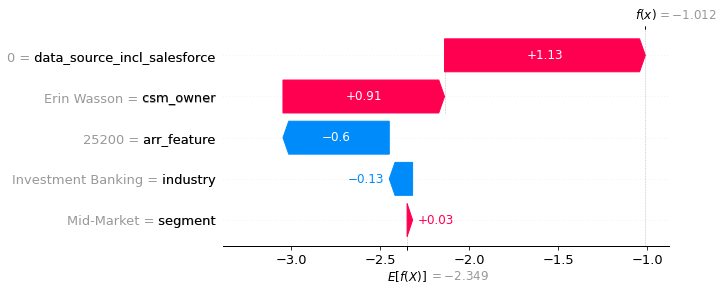

['0014P00003Da2qLQAR' 'Measurabl' 22.86 'Software' 'Mid-Market' 19152.0
 'Brian Silverio' 0.0]


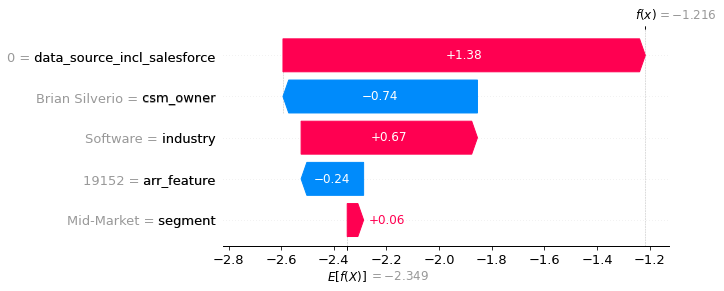

['0014P00003Da5S8QAJ' 'RStudio' 22.78 'Software' 'Mid-Market' 24000.0
 'Mike Portela' 0.0]


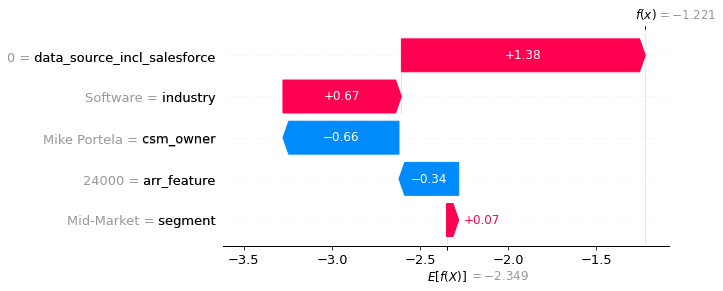

In [251]:
# Force Plots: The blue shows the decrease in the likelihood of churn and red is the increase

df_all_likely_to_churn = df_all_likely_to_churn.reset_index(drop=True)
# print(df_all_likely_to_churn.values[0])
df_for_shap_plot = df_all_likely_to_churn[['industry', 'segment', 'arr_feature', 'csm_owner', 'data_source_incl_salesforce']]

i = 0 

while i < 14:  
  print(df_all_likely_to_churn.values[i]) 
  df = df_for_shap_plot.values[i]

  shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:])
  shap.waterfall_plot(shap_values = explainer(df_for_shap_plot)[i])

  i = i+1 



## CSM Owner
### Below shows the impact of each CSM on the churn likelihood of a client.  
*A client that is more likely to churn will be positive (greater than 0) and a client that is less likely to churn will be negative (less than 0).*

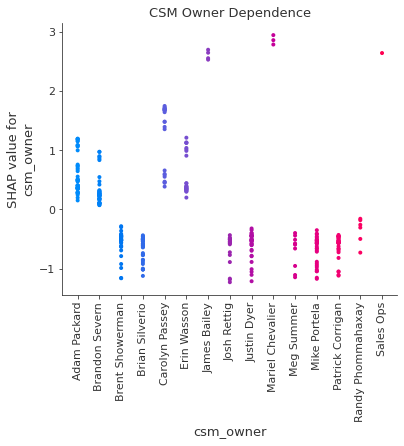

In [201]:
shap.dependence_plot(ind = 'csm_owner', title='CSM Owner Dependence',shap_values = shap_values, features = X_train, interaction_index='csm_owner')

In [202]:
# note - cumulative force plot
shap.initjs()
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)